In [1]:
from pyspark import SparkContext, SparkConf
cf = SparkConf()
cf.set("spark.submit.deployMode","client")
sc = SparkContext.getOrCreate(cf)
from pyspark.sql import SparkSession
spark = SparkSession \
	    .builder \
	    .appName("Python Spark SQL basic example") \
	    .config("spark.some.config.option", "some-value") \
	    .getOrCreate()
                            

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/04 13:15:25 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/05/04 13:15:25 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/05/04 13:15:25 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/05/04 13:15:25 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [93]:
!pip install dataframe_image
import pyspark.sql.functions as F
from pyspark.sql.types import StructField, StructType, StringType, TimestampType, DateType
from pyspark.sql import Window
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import dataframe_image as dfi
import folium
from branca.colormap import LinearColormap, StepColormap


Defaulting to user installation because normal site-packages is not writeable


In [3]:
data = spark.read.csv(path='/shared/TransitTrends/MTA_CLEAN/daily_counts.csv', header=True, inferSchema=True)

complex_id_impute = data.filter((F.col('STATION')=='HOWARD BCH JFK') & (F.col('COMPLEX_ID').isNotNull())).select('COMPLEX_ID').distinct().collect()[0][0]

data = data.withColumn("COMPLEX_ID", F.when((data.STATION == "HOWARD BCH JFK"),complex_id_impute) .otherwise(data.COMPLEX_ID))

data = data.filter((F.col('COMPLEX_ID').isNotNull()))

data = data.groupBy(F.col('STATION'), F.col('COMPLEX_ID') , F.col("DATE")).agg(F.sum("ENTRIES").alias('ENTRIES'),F.sum("EXITS").alias('EXITS'))

In [4]:
data.show(5)

+--------+----------+----------+-------+-----+
| STATION|COMPLEX_ID|      DATE|ENTRIES|EXITS|
+--------+----------+----------+-------+-----+
|BURKE AV|     422.0|2021-04-26|   1461|  826|
|BURKE AV|     422.0|2021-11-19|   1846| 1128|
|BURKE AV|     422.0|2022-01-21|   1474|  926|
|BURKE AV|     422.0|2022-04-29|   1724| 1166|
|BURKE AV|     422.0|2022-10-22|    803|  758|
+--------+----------+----------+-------+-----+
only showing top 5 rows



In [5]:
#Show annual entries and exits
data.groupBy(F.year("DATE").alias("Year")).agg(F.sum("ENTRIES").alias("Entries"),F.sum("EXITS").alias("Exits")).show()

+----+----------+----------+
|Year|   Entries|     Exits|
+----+----------+----------+
|2022| 675984582| 955420186|
|2019|1708033002|1352424801|
|2020| 629352464| 576790684|
|2021| 619953878| 704184381|
+----+----------+----------+



In [6]:
#find daily exits and save as a regular pandas dataframe to plot the same

daily_exits= data.groupBy("DATE").agg(F.sum("EXITS").alias("Exits")).toPandas()

daily_exits['Date'] = pd.to_datetime(daily_exits['DATE'])

daily_exits = daily_exits.sort_values(by='Date')

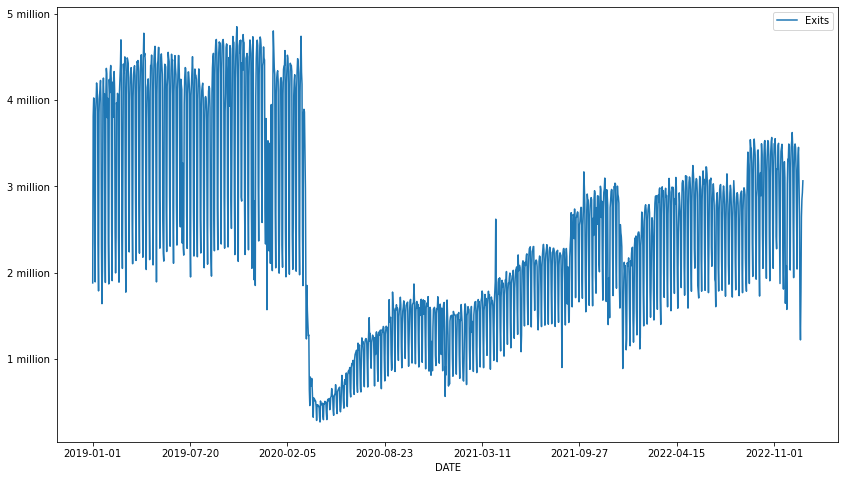

In [7]:
#plot daily exits and save the figure (Saved in the present working directory)
fig, ax = plt.subplots(figsize=(14, 8))
daily_exits.plot.line(x="DATE", y="Exits", ax=ax)

def millions_format(value, tick_number):
    return f'{int(value/1000000)} million'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_format))

plt.savefig('daily_exits_plot.png', dpi=300)

In [8]:
data.filter(F.year("DATE").isin([2019])).groupBy("STATION", "COMPLEX_ID").agg(F.sum("EXITS").alias("Exits")).orderBy("Exits", ascending=False).drop("COMPLEX_ID").show()

+---------------+--------+
|        STATION|   Exits|
+---------------+--------+
|GRD CNTRL-42 ST|40915102|
|34 ST-HERALD SQ|36862009|
| TIMES SQ-42 ST|30284646|
| 14 ST-UNION SQ|30002388|
|42 ST-PORT AUTH|25952100|
| 34 ST-PENN STA|25344698|
|      FULTON ST|24163476|
| 34 ST-PENN STA|24010924|
| 47-50 STS ROCK|19189582|
| 59 ST COLUMBUS|19158642|
|  FLUSHING-MAIN|15498604|
|          59 ST|15249756|
| ATL AV-BARCLAY|13382394|
|42 ST-BRYANT PK|13053408|
| W 4 ST-WASH SQ|13051954|
|          86 ST|13050969|
|LEXINGTON AV/53|12884347|
|JKSN HT-ROOSVLT|12395416|
|          96 ST|11934059|
|       CANAL ST|11394955|
+---------------+--------+
only showing top 20 rows



In [9]:
data.filter(F.year("DATE").isin([2020])).groupBy("STATION", "COMPLEX_ID").agg(F.sum("EXITS").alias("Exits")).orderBy("Exits", ascending=False).drop("COMPLEX_ID").show()

+---------------+--------+
|        STATION|   Exits|
+---------------+--------+
|34 ST-HERALD SQ|13487659|
|GRD CNTRL-42 ST|12955645|
| 14 ST-UNION SQ|10969076|
|42 ST-PORT AUTH|10006958|
| TIMES SQ-42 ST| 9629722|
|      FULTON ST| 8629324|
| 34 ST-PENN STA| 8491324|
| 34 ST-PENN STA| 8428948|
|  FLUSHING-MAIN| 6879968|
| 59 ST COLUMBUS| 6600528|
| 47-50 STS ROCK| 6398874|
|          59 ST| 6052764|
| ATL AV-BARCLAY| 5913758|
|JKSN HT-ROOSVLT| 5753507|
|          86 ST| 5386085|
|          96 ST| 4808597|
|          72 ST| 4711903|
| JAMAICA CENTER| 4632515|
| W 4 ST-WASH SQ| 4628432|
|42 ST-BRYANT PK| 4315280|
+---------------+--------+
only showing top 20 rows



In [10]:
data.filter(F.year("DATE").isin([2021])).groupBy("STATION", "COMPLEX_ID").agg(F.sum("EXITS").alias("Exits")).orderBy("Exits", ascending=False).drop("COMPLEX_ID").show()

+---------------+--------+
|        STATION|   Exits|
+---------------+--------+
|34 ST-HERALD SQ|15589749|
|GRD CNTRL-42 ST|15096203|
| 14 ST-UNION SQ|13799869|
|42 ST-PORT AUTH|12072012|
| TIMES SQ-42 ST|11619074|
| 34 ST-PENN STA|11501016|
|      FULTON ST|10245958|
| 34 ST-PENN STA| 9620604|
|  FLUSHING-MAIN| 9458885|
| 59 ST COLUMBUS| 8278159|
|JKSN HT-ROOSVLT| 7500103|
|          59 ST| 7430750|
|          86 ST| 7062364|
| ATL AV-BARCLAY| 7008793|
| 47-50 STS ROCK| 6773761|
| W 4 ST-WASH SQ| 6445819|
|          72 ST| 6138102|
|          96 ST| 5988155|
|     BEDFORD AV| 5733827|
|       CANAL ST| 5516169|
+---------------+--------+
only showing top 20 rows



In [11]:
data.filter(F.year("DATE").isin([2022])).groupBy("STATION", "COMPLEX_ID").agg(F.sum("EXITS").alias("Exits")).orderBy("Exits", ascending=False).drop("COMPLEX_ID").show()

+---------------+--------+
|        STATION|   Exits|
+---------------+--------+
|GRD CNTRL-42 ST|24467082|
|34 ST-HERALD SQ|22243714|
| TIMES SQ-42 ST|19572419|
| 14 ST-UNION SQ|19276367|
|42 ST-PORT AUTH|16943084|
|      FULTON ST|14806060|
| 34 ST-PENN STA|14632583|
| 34 ST-PENN STA|14625135|
| 59 ST COLUMBUS|12388869|
|  FLUSHING-MAIN|12135263|
| 47-50 STS ROCK|10836725|
|          59 ST|10524412|
|          86 ST| 9725733|
| ATL AV-BARCLAY| 9619619|
|JKSN HT-ROOSVLT| 9283965|
| W 4 ST-WASH SQ| 9133165|
|          72 ST| 8415115|
|     BEDFORD AV| 8259839|
|          96 ST| 7869039|
|42 ST-BRYANT PK| 7812003|
+---------------+--------+
only showing top 20 rows



In [31]:
#Filter data by year and then convert it to a a Pandas Dataframe to generate visualizations
station_exits_2019=data.filter(F.year("DATE").isin([2019])).groupBy("STATION", "COMPLEX_ID").agg(F.sum("EXITS").alias("Exits")).orderBy("Exits", ascending=False).toPandas()
station_exits_2020=data.filter(F.year("DATE").isin([2020])).groupBy("STATION", "COMPLEX_ID").agg(F.sum("EXITS").alias("Exits")).orderBy("Exits", ascending=False).toPandas()
station_exits_2021=data.filter(F.year("DATE").isin([2021])).groupBy("STATION", "COMPLEX_ID").agg(F.sum("EXITS").alias("Exits")).orderBy("Exits", ascending=False).toPandas()
station_exits_2022=data.filter(F.year("DATE").isin([2022])).groupBy("STATION", "COMPLEX_ID").agg(F.sum("EXITS").alias("Exits")).orderBy("Exits", ascending=False).toPandas()


In [52]:
#Get Lat and Lon of stations
station_locations=spark.read.csv('/shared/TransitTrends/station_locations.csv' ,header=True).toPandas()
station_locations["Complex ID"] = station_locations["Complex ID"].astype(int)
station_locations.drop_duplicates(subset=["Complex ID"], inplace=True)

In [70]:
percent_change_2020=pd.merge(station_exits_2019, station_exits_2020,  how='left', left_on=['STATION','COMPLEX_ID'], right_on = ['STATION','COMPLEX_ID'])
percent_change_2020.rename(columns = {'Exits_x':'2019_Exits', 'Exits_y':'2020_Exits'}, inplace = True)
#head(5)[["STATION", "COMPLEX_ID", '2019_Exits','2020_Exits','percent_change']].reset_index(drop=True)
percent_change_2020['COMPLEX_ID'] = percent_change_2020['COMPLEX_ID'].astype(int)
percent_change_2020=pd.merge(percent_change_2020, station_locations[["Complex ID", "GTFS Latitude", "GTFS Longitude" , "Borough"]],  how='left', left_on=['COMPLEX_ID'], right_on = ['Complex ID'])
percent_change_2020["percent_change"]= (percent_change_2020['2020_Exits']-percent_change_2020['2019_Exits'])*100/percent_change_2020['2019_Exits']


,STATION,COMPLEX_ID,2019_Exits,2020_Exits,Complex ID,GTFS Latitude,GTFS Longitude,Borough,percent_change
0,GRD CNTRL-42 ST,610,40915102,12955645,610,40.751776,-73.976848,M,-68.335298
1,34 ST-HERALD SQ,607,36862009,13487659,607,40.749567,-73.98795,M,-63.410407
2,TIMES SQ-42 ST,611,30284646,9629722,611,40.754672,-73.986754,M,-68.202627
3,14 ST-UNION SQ,602,30002388,10969076,602,40.735736,-73.990568,M,-63.439324
4,42 ST-PORT AUTH,611,25952100,10006958,611,40.754672,-73.986754,M,-61.440662
...,...,...,...,...,...,...,...,...,...
436,145 ST,437,73774,61433,437,40.820421,-73.936245,M,-16.728116
437,DYCKMAN ST,144,68979,40984,144,40.865491,-73.927271,M,-40.584816
438,AQUEDUCT RACETR,196,59870,24934,196,40.672097,-73.835919,Q,-58.353098
439,BROAD CHANNEL,199,25296,18608,199,40.608382,-73.815925,Q,-26.438963


In [81]:
percent_change_2020.sort_values('percent_change', ascending = False)

,STATION,COMPLEX_ID,2019_Exits,2020_Exits,Complex ID,GTFS Latitude,GTFS Longitude,Borough,percent_change
374,ASTORIA BLVD,2,599194,1097860,2,40.770258,-73.917843,Q,83.222796
333,39 AV,6,811784,1034662,6,40.752882,-73.932755,Q,27.455333
282,EUCLID AV,188,1093026,1082237,188,40.675377,-73.872106,Bk,-0.987076
138,168 ST,605,2728088,2470990,605,40.840719,-73.939561,M,-9.424109
424,111 ST,81,218702,192024,81,40.697418,-73.836345,Q,-12.198334
...,...,...,...,...,...,...,...,...,...
24,5 AV/53 ST,276,8530986,2473421,276,40.760167,-73.975224,M,-71.006622
173,METS-WILLETS PT,448,2099993,528727,448,40.754622,-73.845625,Q,-74.822440
440,TOMPKINSVILLE,502,12,3,502,40.636949,-74.074835,SI,-75.000000
125,CANARSIE-ROCKAW,138,2972064,673744,138,40.646654,-73.90185,Bk,-77.330771


In [116]:
#Plot map using folium
nyc_coords = (40.72, -73.95)
map = folium.Map(location=nyc_coords, zoom_start=11)
neg_colormap = LinearColormap(colors=["red", "yellow"], vmin=-100, vmax=0)
pos_colormap = LinearColormap(colors=["#0eff00", "#063b00"], vmin=0, vmax=100)

for index, row in percent_change_2020[percent_change_2020['percent_change']<0].iterrows():
    coords = (row["GTFS Latitude"], row["GTFS Longitude"])
    tooltip = f"{row['STATION']}, {row['Borough']}"
    color = colormap(row["percent_change"])
    radius = 6 # adjust the size of the circle based on the magnitude of the percent change
    marker = folium.CircleMarker(location=coords, tooltip=tooltip, radius=radius, fill=True, color=color, fill_opacity=0.7)
    marker.add_to(map)
    
for index, row in percent_change_2020[percent_change_2020['percent_change']>0].iterrows():
    coords = (row["GTFS Latitude"], row["GTFS Longitude"])
    tooltip = f"{row['STATION']}, {row['Borough']}"
    color = pos_colormap(row["percent_change"])
    radius = 7 # adjust the size of the circle based on the magnitude of the percent change
    marker = folium.CircleMarker(location=coords, tooltip=tooltip, radius=radius, fill=True, color=color, fill_opacity=1)
    marker.add_to(map)
map

In [24]:
max_reductions=percent_change[(percent_change['2019_Exits'] > 10000)] .sort_values(by="percent_change",ascending=True).head(5)[["STATION", "COMPLEX_ID", '2019_Exits','2020_Exits','percent_change']].reset_index(drop=True)
print("Stations with the highest Decrease in Usage Through 2020:")
max_reductions


Stations with the highest Decrease in Usage Through 2020:


,STATION,COMPLEX_ID,2019_Exits,2020_Exits,percent_change
0,ST. GEORGE,501.0,101407,428,-99.577938
1,CANARSIE-ROCKAW,138.0,2972064,673744,-77.330771
2,METS-WILLETS PT,448.0,2099993,528727,-74.822440
3,5 AV/53 ST,276.0,8530986,2473421,-71.006622
4,WALL ST,413.0,4306551,1250852,-70.954669


In [26]:
percent_change=pd.merge(station_exits_2019, station_exits_2022,  how='left', left_on=['STATION','COMPLEX_ID'], right_on = ['STATION','COMPLEX_ID'])
percent_change.rename(columns = {'Exits_x':'2019_Exits', 'Exits_y':'2022_Exits'}, inplace = True)
percent_change["percent_change"] = (percent_change['2022_Exits']-percent_change['2019_Exits'])*100/percent_change['2019_Exits']
percent_change.sort_values(by="percent_change",ascending=False).head(10)[["STATION", "COMPLEX_ID", '2019_Exits','2022_Exits','percent_change']].reset_index(drop=True)

,STATION,COMPLEX_ID,2019_Exits,2022_Exits,percent_change
0,ASTORIA BLVD,2.0,599194,2171722,262.440545
1,LORIMER ST,629.0,418790,1445661,245.199503
2,GUN HILL RD,444.0,751016,1275798,69.876274
3,FT HAMILTON PKY,72.0,591902,904186,52.759409
4,168 ST,605.0,2728088,4081678,49.616801
5,111 ST,81.0,218702,319592,46.131265
6,59 ST,35.0,1811055,2574842,42.173595
7,145 ST,437.0,73774,104815,42.075799
8,BEDFORD AV,120.0,5830396,8259839,41.668576
9,BAY 50 ST,70.0,176767,217197,22.871916


Defaulting to user installation because normal site-packages is not writeable
